In [218]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Data && Parameter settings

### Hyper parameters

In [219]:
interval = '4h'
shift_interval = -3 # 몇 번째 후를 예측할지
patience = 50
lr = 0.0002
epochs = 600

In [220]:
# Load data
btc_data = pd.read_csv(f'data/btc_{interval}_data_with_ma.csv', index_col=False, parse_dates=['timestamp'])
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])

In [221]:
# scenario 2: bear only
# btc_data = btc_data[(btc_data['timestamp'] >= '2021-11-10') & (btc_data['timestamp'] <= '2023-01-05')]

In [222]:
def calculate_rsi(df, window=14):
    delta = df['close'].diff(1)  # Price changes between each day
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Calculate average gains
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Calculate average losses
    rs = gain / loss  # Relative Strength (RS)
    rsi = 100 - (100 / (1 + rs))  # RSI formula
    df['rsi'] = rsi
    return df

In [223]:
btc_data = calculate_rsi(btc_data)

# MACD

In [224]:
btc_data['EMA_12'] = btc_data['close'].ewm(span=12, adjust=False).mean()
btc_data['EMA_26'] = btc_data['close'].ewm(span=26, adjust=False).mean()

# Calculate MACD Line
btc_data['MACD_Line'] = btc_data['EMA_12'] - btc_data['EMA_26']

# Calculate Signal Line (9-period EMA of MACD Line)
btc_data['Signal_Line'] = btc_data['MACD_Line'].ewm(span=9, adjust=False).mean()

# Calculate MACD Histogram
btc_data['MACD_Histogram'] = btc_data['MACD_Line'] - btc_data['Signal_Line']

btc_data = btc_data.drop(columns=['EMA_12', 'EMA_26'])

In [225]:
features = ['open', 'high', 'low', 'close', 'volume', 'rsi']
features_MACD = ['MACD_Line', 'Signal_Line', 'MACD_Histogram']
features_MA = ['MA_30', 'MA_60', 'MA_90', 'MA_120', 'MA_250', 'MA_260', 'MA_1020'] # for 4h
# features_MA = ['MA_40', 'MA_60', 'MA_90', 'MA_120', 'MA_200'] # for 1h or 15m chart
features += features_MACD + features_MA 

In [226]:
btc_data.head()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_1010,MA_1020,MA_1030,MA_1040,MA_1050,MA_1060,rsi,MACD_Line,Signal_Line,MACD_Histogram
0,2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.167179,1.233436,4.933744
2,2017-08-17 12:00:00,4436.06,4485.39,4333.42,4352.34,174.562001,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.949019,1.976553,2.972466
3,2017-08-17 16:00:00,4352.33,4354.84,4200.74,4325.23,225.109716,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.775599,1.936362,-0.160762
4,2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.933782,0.762333,-4.696115


# Shift data (predict next close)

In [227]:
# Shift the 'close' column values forward by one space
btc_data['next_close'] = btc_data['close'].shift(shift_interval)

# Display the first few rows to check the result
# btc_data[['timestamp', 'close', 'close_shifted']].head()
features += ['next_close']

## Processing Nan data

In [228]:
data_filled = btc_data.ffill()
data_filled = data_filled.bfill()
data_filled = data_filled.dropna()

# Get the maximum window size from MA columns
ma_columns = features_MA
ma_window_sizes = [int(col.split('_')[1]) for col in features_MA]
max_ma_window = max(ma_window_sizes) # 1020

# Remove the initial rows where moving averages are NaN
# data_cleaned = btc_data.iloc[max_ma_window:]

In [229]:
data_filled.tail()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_1020,MA_1030,MA_1040,MA_1050,MA_1060,rsi,MACD_Line,Signal_Line,MACD_Histogram,next_close
15678,2024-10-14 20:00:00,65939.41,66500.0,65730.0,66083.99,3881.13909,64212.929,63547.3645,62651.340667,62591.3946,...,62769.402784,62775.463068,62789.609058,62822.391305,62849.214302,76.811137,953.159559,607.171790,345.987769,65399.69
15679,2024-10-15 00:00:00,66084.00,66330.0,65324.4,65400.00,3574.82599,64496.796,63663.0640,62802.497667,62646.7670,...,62770.754137,62776.585379,62790.978231,62821.405581,62849.370896,70.052957,960.650095,677.867451,282.782645,67571.80
15680,2024-10-15 04:00:00,65399.99,65846.0,65201.0,65638.74,3319.36953,64837.739,63818.0010,62960.455667,62703.1436,...,62772.443588,62778.658699,62792.275490,62820.966486,62849.932264,70.214870,974.615957,737.217152,237.398805,67571.80
15681,2024-10-15 08:00:00,65638.74,65850.0,65280.0,65399.69,3798.65244,65104.276,63959.5855,63098.378667,62740.5272,...,62774.321706,62780.268058,62793.350183,62820.352867,62850.745179,73.320664,955.381620,780.850046,174.531575,67571.80
15682,2024-10-15 12:00:00,65399.68,67950.0,65383.5,67571.80,6878.70128,65574.454,64199.7970,63324.460000,62821.3234,...,62778.274451,62783.959117,62796.767308,62821.450238,62853.226925,80.299100,1102.698176,845.219672,257.478504,67571.80


# Scaling

In [230]:
scaler = MinMaxScaler()
# scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_filled[features])

In [231]:
data_filled.head()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_1020,MA_1030,MA_1040,MA_1050,MA_1060,rsi,MACD_Line,Signal_Line,MACD_Histogram,next_close
0,2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865,4304.606,4191.461,4142.801667,4137.9686,...,8553.405137,8557.07733,8543.852808,8535.998981,8536.229708,22.66832,0.000000,0.000000,0.000000,4325.23
1,2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882,4304.606,4191.461,4142.801667,4137.9686,...,8553.405137,8557.07733,8543.852808,8535.998981,8536.229708,22.66832,6.167179,1.233436,4.933744,4285.08
2,2017-08-17 12:00:00,4436.06,4485.39,4333.42,4352.34,174.562001,4304.606,4191.461,4142.801667,4137.9686,...,8553.405137,8557.07733,8543.852808,8535.998981,8536.229708,22.66832,4.949019,1.976553,2.972466,4292.39
3,2017-08-17 16:00:00,4352.33,4354.84,4200.74,4325.23,225.109716,4304.606,4191.461,4142.801667,4137.9686,...,8553.405137,8557.07733,8543.852808,8535.998981,8536.229708,22.66832,1.775599,1.936362,-0.160762,4300.25
4,2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913,4304.606,4191.461,4142.801667,4137.9686,...,8553.405137,8557.07733,8543.852808,8535.998981,8536.229708,22.66832,-3.933782,0.762333,-4.696115,4340.31


In [232]:
scaled_data.shape

(15683, 17)

In [233]:
scaled_data

array([[0.0197306 , 0.01701836, 0.02063226, ..., 0.00839376, 0.07321382,
        0.01996628],
       [0.02074992, 0.01893542, 0.02166079, ..., 0.00839376, 0.07321382,
        0.01939621],
       [0.02220767, 0.01893542, 0.02166221, ..., 0.00839376, 0.07321382,
        0.0195    ],
       ...,
       [0.88721003, 0.88770901, 0.89116181, ..., 0.89052223, 0.9654588 ,
        0.91796933],
       [0.89059759, 0.88776565, 0.89229033, ..., 0.89097939, 0.96548971,
        0.91796933],
       [0.88720563, 0.91749848, 0.89376884, ..., 0.8915778 , 0.96555476,
        0.91796933]])

# Sequences

In [234]:
def create_sequences(data, sequence_length=10):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        # y.append(data[i, features.index('close')])
        y.append(data[i, features.index('next_close')])
    return np.array(X), np.array(y)

sequence_length = 1
X, y = create_sequences(scaled_data, sequence_length)

In [235]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [236]:
X_train.shape

(14113, 1, 17)

In [237]:
y_train.shape

(14113,)

In [238]:
X_test.shape

(1569, 1, 17)

In [239]:
y_test.shape

(1569,)

In [240]:
btc_data.tail()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_1020,MA_1030,MA_1040,MA_1050,MA_1060,rsi,MACD_Line,Signal_Line,MACD_Histogram,next_close
15678,2024-10-14 20:00:00,65939.41,66500.0,65730.0,66083.99,3881.13909,64212.929,63547.3645,62651.340667,62591.3946,...,62769.402784,62775.463068,62789.609058,62822.391305,62849.214302,76.811137,953.159559,607.171790,345.987769,65399.69
15679,2024-10-15 00:00:00,66084.00,66330.0,65324.4,65400.00,3574.82599,64496.796,63663.0640,62802.497667,62646.7670,...,62770.754137,62776.585379,62790.978231,62821.405581,62849.370896,70.052957,960.650095,677.867451,282.782645,67571.80
15680,2024-10-15 04:00:00,65399.99,65846.0,65201.0,65638.74,3319.36953,64837.739,63818.0010,62960.455667,62703.1436,...,62772.443588,62778.658699,62792.275490,62820.966486,62849.932264,70.214870,974.615957,737.217152,237.398805,NaN
15681,2024-10-15 08:00:00,65638.74,65850.0,65280.0,65399.69,3798.65244,65104.276,63959.5855,63098.378667,62740.5272,...,62774.321706,62780.268058,62793.350183,62820.352867,62850.745179,73.320664,955.381620,780.850046,174.531575,NaN
15682,2024-10-15 12:00:00,65399.68,67950.0,65383.5,67571.80,6878.70128,65574.454,64199.7970,63324.460000,62821.3234,...,62778.274451,62783.959117,62796.767308,62821.450238,62853.226925,80.299100,1102.698176,845.219672,257.478504,NaN


In [241]:
print(f"Type of X_train: {type(X_train)}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Data type of X_train elements: {X_train.dtype}")

Type of X_train: <class 'numpy.ndarray'>
Shape of X_train: (14113, 1, 17)
Data type of X_train elements: float64


# Check NaN

In [242]:
def check_for_nans_and_infs(data, name):
    nan_count = np.isnan(data).sum()
    inf_count = np.isinf(data).sum()
    print(f"{name} - NaNs: {nan_count}, Infs: {inf_count}")

# Check X_train
check_for_nans_and_infs(X_train, 'X_train')

# Check y_train
check_for_nans_and_infs(y_train, 'y_train')

# Check X_test
check_for_nans_and_infs(X_test, 'X_test')

# Check y_test
check_for_nans_and_infs(y_test, 'y_test')
check_for_nans_and_infs(scaled_data, 'scaled_data')


X_train - NaNs: 0, Infs: 0
y_train - NaNs: 0, Infs: 0
X_test - NaNs: 0, Infs: 0
y_test - NaNs: 0, Infs: 0
scaled_data - NaNs: 0, Infs: 0


# Model & train (Keras)

In [243]:
# import time
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# # Define the model
# model = Sequential()
# model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
# model.add(LSTM(512, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(512))
# model.add(Dropout(0.2))
# model.add(Dense(1))

# optimizer = Adam(learning_rate=lr)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

# early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# start_time = time.time()
# history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
# end_time = time.time()
# print(f"Time taken to fit the model: {end_time - start_time} seconds")

# Keras (GridSearch)

In [244]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

# Define the model creation function
def create_lstm_model(unit=256, dropout_rate=0.2, lr=lr, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(unit, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(unit))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    # Compile the model
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Wrap the model using KerasRegressor
model = KerasRegressor(model=create_lstm_model, verbose=0)

# Define the grid of hyperparameters
# param_grid = {
#     'model__unit': [128, 256, 512, 1024],
#     'model__dropout_rate': [0, 0.2, 0.3],
#     'batch_size': [32, 64],
#     'epochs': [100, 150, 200, 250, 300],
#     'model__lr': [0.001, 0.0001, 0.0003, 0.003, 0.01, 0.03]
# }

param_grid = {
    'model__unit': [128],
    'model__dropout_rate': [0.2],
    'batch_size': [32, 64],
    'epochs': [100, 150],
    'model__lr': [0.001, 0.01]
}

# print(model.get_params().keys())
# assert()

# Set up GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, scoring=rmse_scorer)

# Fit the grid search
grid_result = grid.fit(X_train, y_train)

In [190]:
# Output the best parameters and score
print("Best parameters found: ", grid_result.best_params_)
print("Best score achieved: ", grid_result.best_score_)

NameError: name 'grid_result' is not defined

# Model & train (torch)

In [286]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
# import numpy as np

# # Assuming you have variables `X_train`, `y_train`, `lr`, `epochs`, and `patience` defined
# # Convert your training data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# # Calculate the split index for sequential splitting
# validation_split = 0.2  # Same as validation_split=0.2 in Keras
# dataset_size = len(X_train_tensor)
# split_index = int(dataset_size * (1 - validation_split))

# # Sequentially split the data
# X_train_seq = X_train_tensor[:split_index]
# y_train_seq = y_train_tensor[:split_index]
# X_val_seq = X_train_tensor[split_index:]
# y_val_seq = y_train_tensor[split_index:]

# # Create TensorDatasets
# train_dataset = TensorDataset(X_train_seq, y_train_seq)
# val_dataset = TensorDataset(X_val_seq, y_val_seq)

# # Create DataLoaders for batching without shuffling
# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# # Define the LSTM model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size=50, dropout_rate=0.2):
#         super(LSTMModel, self).__init__()
#         self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         # First LSTM layer with return_sequences=True
#         out, _ = self.lstm1(x)
#         out = self.dropout1(out)
#         # Second LSTM layer
#         out, _ = self.lstm2(out)
#         out = out[:, -1, :]  # Take the output of the last time step
#         out = self.dropout2(out)
#         # Fully connected layer
#         out = self.fc(out)
#         return out

# # Initialize the model, loss function, and optimizer
# input_size = X_train.shape[2]  # Number of features
# model = LSTMModel(input_size=input_size, hidden_size=50, dropout_rate=0.2)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # device = torch.device("mps" if torch.backends.mps.is_built() or torch.backends.mps.is_available() else 'cpu')
# model.to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)

# # Implement early stopping
# best_val_loss = float('inf')
# patience_counter = 0
# best_model_state = None

# train_loss_history = []
# val_loss_history = []

# for epoch in range(epochs):
#     # Training phase
#     model.train()
#     train_losses = []
#     for X_batch, y_batch in train_loader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)

#         optimizer.zero_grad()
#         outputs = model(X_batch)
#         loss = criterion(outputs.view(-1), y_batch)
#         loss.backward()
#         optimizer.step()

#         train_losses.append(loss.item())

#     avg_train_loss = np.mean(train_losses)
#     train_loss_history.append(avg_train_loss)

#     # Validation phase
#     model.eval()
#     val_losses = []
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             X_batch = X_batch.to(device)
#             y_batch = y_batch.to(device)

#             outputs = model(X_batch)
#             loss = criterion(outputs.view(-1), y_batch)
#             val_losses.append(loss.item())

#     avg_val_loss = np.mean(val_losses)
#     val_loss_history.append(avg_val_loss)

#     print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

#     # Check for early stopping
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         best_model_state = model.state_dict()
#         patience_counter = 0
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

# # Restore the best model weights
# model.load_state_dict(best_model_state)

# Figure

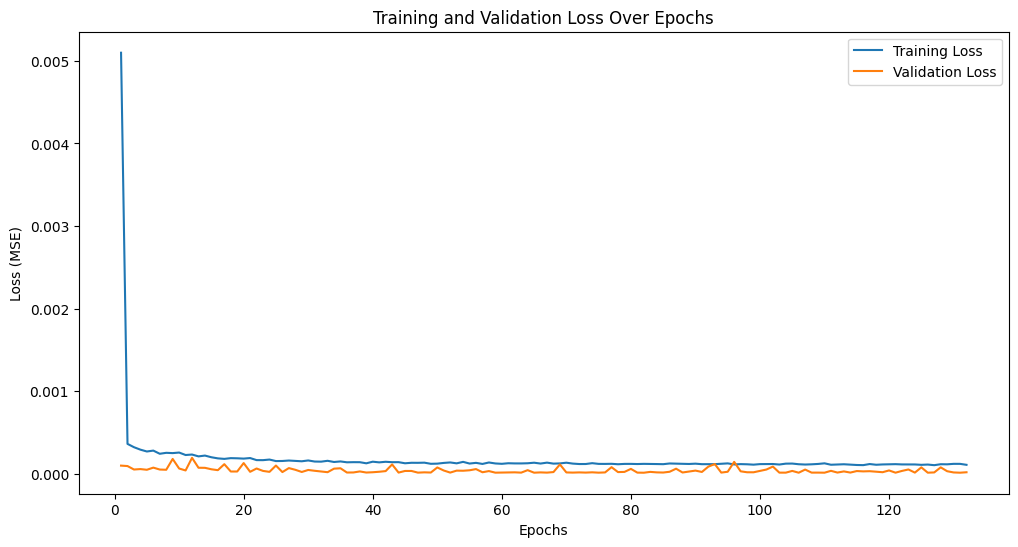

In [287]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Size up the figure

# epochs_range = range(1, len(train_loss_history) + 1)  # Get the range of epochs
# plt.plot(epochs_range, train_loss_history, label='Training Loss')
# plt.plot(epochs_range, val_loss_history, label='Validation Loss')

epochs = range(1, len(history.history['loss']) + 1)  # Get number of epochs

plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')  # Annotate x-axis with epochs
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

#

# Prediction

In [288]:
# Ensure that your model is in evaluation mode
# model.eval()

# Convert X_test to a PyTorch tensor and move it to the appropriate device
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Make predictions without computing gradients
# with torch.no_grad():
    # y_pred = model(X_test_tensor)

# Move predictions to CPU and convert to NumPy array
# y_pred = y_pred.cpu().numpy()

y_pred = model.predict(X_test)

# Get the index of 'next_close' in the features list
close_index = features.index('next_close')

# Retrieve the min and max values for 'next_close' from the scaler
close_min = scaler.data_min_[close_index]
close_max = scaler.data_max_[close_index]

# Inverse transform the scaled 'close' prices
y_test_actual = y_test * (close_max - close_min) + close_min
y_pred_actual = y_pred[:, 0] * (close_max - close_min) + close_min

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


# Backtesting

In [289]:
initial_balance = 10000  # Starting with $10,000
balance = initial_balance
btc_holdings = 0
positions = []

btc_data_tail_df = btc_data.tail(y_test.shape[0])
base_price = btc_data_tail_df['close'].iloc[0]
final_price = btc_data_tail_df['close'].iloc[-1]
base_portfolio_value = ((final_price - base_price) / base_price + 1) * initial_balance
print(f"Baseline portfilio value: {base_portfolio_value:,.2f} USDT")  

for i in range(len(y_pred_actual)):
    current_time = btc_data_tail_df['timestamp'].iloc[i]
    predicted_price = y_pred_actual[i]
    # current_price = y_test_actual[i]
    current_price = btc_data_tail_df['close'].iloc[i]

    if predicted_price > current_price:
        # Buy signal
        if balance > 0:
            btc_holdings = balance / current_price
            balance = 0
            positions.append(('Buy', current_price))
            print(f"{current_time}: Bought BTC at {current_price:,.2f}, holding {btc_holdings:.4f} BTC")
    else:
        # Sell signal
        if btc_holdings > 0:
            balance = btc_holdings * current_price
            btc_holdings = 0
            positions.append(('Sell', current_price))
            print(f"{current_time}: Sold BTC at {current_price:,.2f}, now holding {balance:,.2f} USDT")

# Calculate final portfolio value
final_balance = balance + btc_holdings * y_test_actual[-1]
profit = final_balance - initial_balance
# print(f"Initial Balance: {initial_balance:,.2f}")
# print(f"Profit: {profit:,.2f}")
print(f"Final Balance: {final_balance:,.2f}")

if final_balance > base_portfolio_value:
    print("Out Performed !!!!!!!!")

Baseline portfilio value: 15,940.95 USDT
2024-01-28 16:00:00: Bought BTC at 41,785.92, holding 0.2393 BTC
2024-01-29 00:00:00: Sold BTC at 42,331.20, now holding 10,130.49 USDT
2024-01-29 04:00:00: Bought BTC at 42,053.46, holding 0.2409 BTC
2024-01-30 12:00:00: Sold BTC at 43,375.50, now holding 10,448.97 USDT
2024-01-30 20:00:00: Bought BTC at 42,941.10, holding 0.2433 BTC
2024-01-31 00:00:00: Sold BTC at 42,930.07, now holding 10,446.28 USDT
2024-01-31 04:00:00: Bought BTC at 43,050.01, holding 0.2427 BTC
2024-01-31 12:00:00: Sold BTC at 43,361.10, now holding 10,521.77 USDT
2024-02-01 00:00:00: Bought BTC at 42,015.65, holding 0.2504 BTC
2024-02-01 16:00:00: Sold BTC at 43,218.94, now holding 10,823.10 USDT
2024-02-01 20:00:00: Bought BTC at 43,082.94, holding 0.2512 BTC
2024-02-02 08:00:00: Sold BTC at 43,148.41, now holding 10,839.55 USDT
2024-02-02 12:00:00: Bought BTC at 43,242.09, holding 0.2507 BTC
2024-02-02 20:00:00: Sold BTC at 43,200.00, now holding 10,829.00 USDT
2024-02

MAE: 877.91
RMSE: 1061.88
MSE: 1127588.94
R²: 0.9739


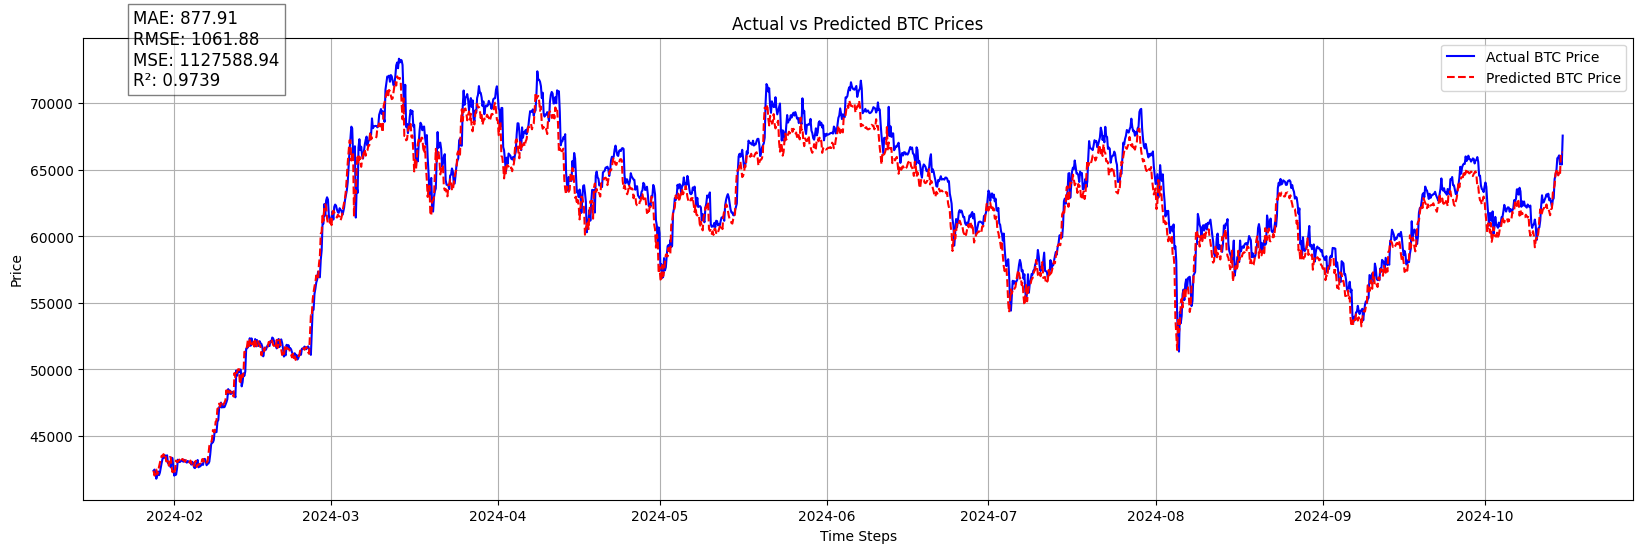

In [290]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

textstr = '\n'.join((
    f'MAE: {mae:.2f}',
    f'RMSE: {rmse:.2f}',
    f'MSE: {mse:.2f}',
    f'R²: {r2:.4f}',
))

print(textstr)

plt.figure(figsize=(20, 6))

# plt.plot(y_test_actual, color='blue', label='Actual BTC Price')
# plt.plot(btc_data_tail_df.timestamp, y_test_actual, color='blue', label='Actual BTC Price')
plt.plot(btc_data_tail_df.timestamp, btc_data_tail_df.close, color='blue', label='Actual BTC Price')
plt.plot(btc_data_tail_df.timestamp, y_pred_actual, color='red', linestyle='--', label='Predicted BTC Price')
plt.title('Actual vs Predicted BTC Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Display metrics in the plot
plt.gcf().text(0.15, 0.8, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()